# Sales Analysis
AAL, established in 2000, is a well-known brand in Australia, particularly recognized for its clothing business. It has opened branches in various states, metropolises, and tier-1 and tier-2 cities across the country.
The brand caters to all age groups, from kids to the elderly.
Currently experiencing a surge in business, AAL is actively pursuing expansion opportunities. To facilitate informed investment decisions, the CEO has assigned the responsibility to the head of AAL’s sales and marketing (S&M) department. The specific tasks include:
Identify the states that are generating the highest revenues.
Develop sales programs for states with lower revenues. The head of sales and marketing has requested your assistance with this task.
Analyze the sales data of the company for the fourth quarter in Australia, examining it on a state-by-state basis. Provide insights to assist the company in making data-driven decisions for the upcoming year.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import f_oneway

df = pd.read_csv('AusApparalSales4thQrt2020.csv')

# Data Wrangling:
### Inspection of Data

In [3]:
def inspect(sample):
    print(sample.sample(5),"\n")
    sample.info() 
    print(sample.describe(),"\n")
inspect(df)

             Date        Time State     Group  Unit  Sales
4165  20-Nov-2020     Morning   QLD       Men     7  17500
31     1-Oct-2020   Afternoon    SA   Seniors    29  72500
4264  21-Nov-2020   Afternoon   NSW      Kids    29  72500
2156  26-Oct-2020     Evening   QLD      Kids     7  17500
5825  10-Dec-2020   Afternoon    SA       Men    32  80000 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7560 entries, 0 to 7559
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    7560 non-null   object
 1   Time    7560 non-null   object
 2   State   7560 non-null   object
 3   Group   7560 non-null   object
 4   Unit    7560 non-null   int64 
 5   Sales   7560 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 354.5+ KB
              Unit          Sales
count  7560.000000    7560.000000
mean     18.005423   45013.558201
std      12.901403   32253.506944
min       2.000000    5000.000000
25%       8.000000   20000.0

Currently there are 7560 logged entries. "Unit" and "Sales" columns yield numerical data while "Time", "State, and "Group" columns yield categorical data. "Date" column may be converted to datetime for manipulation of time intervals and categorical data has the potential to be encoded for statistical analysis if desired

### Examined Data for duplicates and missing values. 
All duplicates found would be dropped and missing values will be filled with mean value to minimize skewing data

In [4]:
def clean_data(sample):
    if sample.duplicated().sum() > 0:
        sample.drop_duplicates(inplace = True)
        print(f'Duplicates were dropped in Data') 
    if sample.duplicated().sum() == 0:
        print(f"No duplicates found in Data")
    for col in sample:
        if sample[col].isnull().sum() > 0:
            mean_value = df[col].mean()
            print(f"Filling missing values in '{col}' with mean value: {mean_value:.2f}")
            sample[col].fillna(mean_value, inplace=True)
        if sample[col].isnull().sum() == 0:
            print(f"No missing values in {col}")
clean_data(df)

No duplicates found in Data
No missing values in Date
No missing values in Time
No missing values in State
No missing values in Group
No missing values in Unit
No missing values in Sales


### Converting Dates to Datetime for temporal data manipulation

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
print('Dates have been converted to Datetime and formatted to "YXXX-MX-DX"')

Dates have been converted to Datetime and formatted to "YXXX-MX-DX"


### Viewing Distribution of Numerical Data

#### Histogram of Unit and Sales

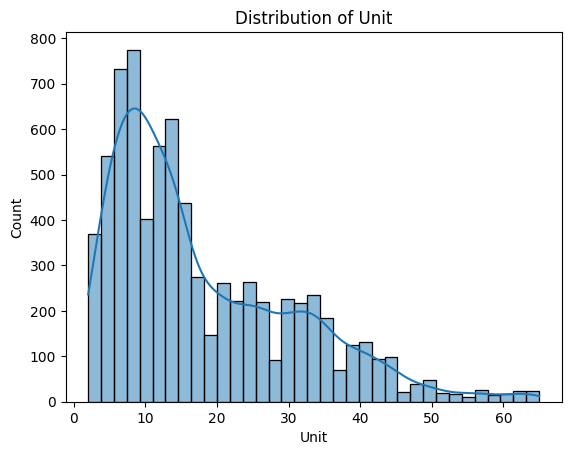

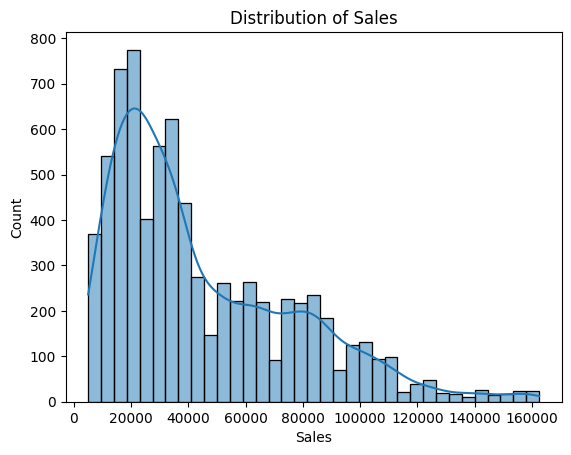

In [6]:
rev_columns = df.select_dtypes(include=np.number).columns
for column in rev_columns:
    sns.histplot(df[column], kde=True)
    plt.title(f"Distribution of {column}")
    plt.show()

### Examination of Outliers

#### Boxplot of Unit and Sales

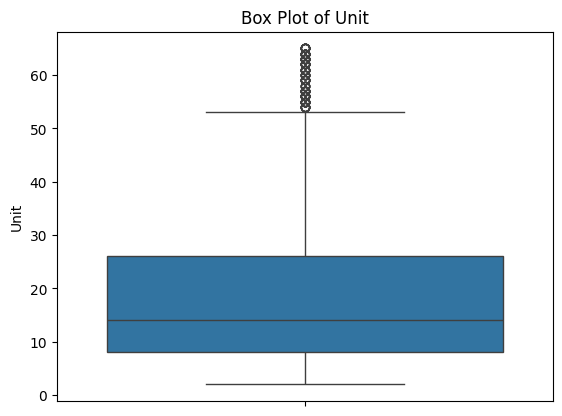

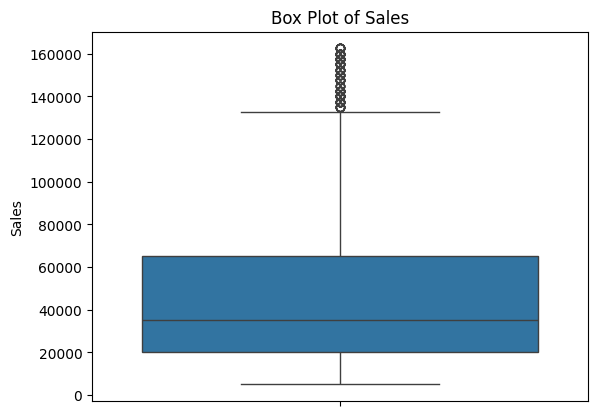

In [7]:
for column in rev_columns:
    sns.boxplot(y=df[column])
    plt.title(f"Box Plot of {column}")
    plt.show()

Distribution of Sales and Units suggest data may be positively skewed with a longer right tail. However, since we are examining total sums of sales, eliminating outliers may be unnecessary for our purposes  when we are simply analyzing sales that generate highest revenues.

#### Boxplot of weekly sales

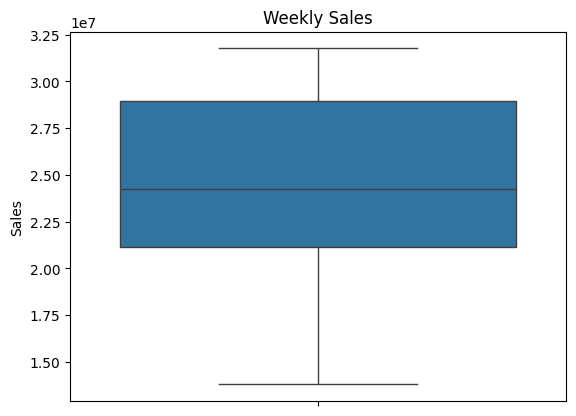

In [8]:
df['Week'] = df['Date'].dt.isocalendar().week
weekly_sales = df.groupby('Week')['Sales'].sum().reset_index()
sns.boxplot(y=weekly_sales['Sales'])
plt.title(f"Weekly Sales")
plt.show()

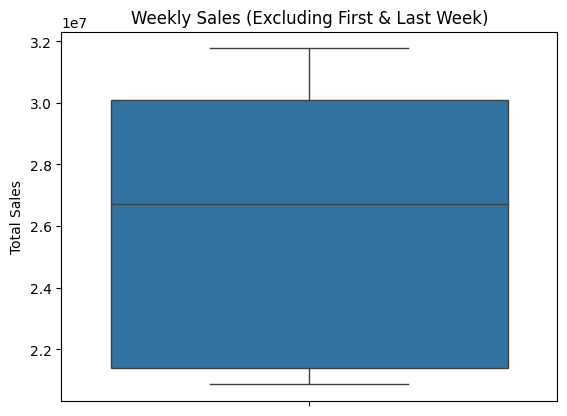

In [9]:
first_week = weekly_sales['Week'].min()
last_week = weekly_sales['Week'].max()
filtered_sales = weekly_sales[(weekly_sales['Week'] != first_week) & (weekly_sales['Week'] != last_week)]
sns.boxplot(y=filtered_sales['Sales'])
plt.title("Weekly Sales (Excluding First & Last Week)")
plt.ylabel("Total Sales")
plt.show()

## Normalization of numerical data

In [10]:
scaler = MinMaxScaler()
df_MinMax = df.copy()
df_MinMax[rev_columns] = scaler.fit_transform(df[rev_columns])
print(df_MinMax[rev_columns])

          Unit     Sales
0     0.095238  0.095238
1     0.095238  0.095238
2     0.031746  0.031746
3     0.206349  0.206349
4     0.015873  0.015873
...        ...       ...
7555  0.190476  0.190476
7556  0.206349  0.206349
7557  0.206349  0.206349
7558  0.142857  0.142857
7559  0.174603  0.174603

[7560 rows x 2 columns]


Sales and units are normalized and scaled between 0 to 1 for potential further use in machine learning models. Values appear to be the same, illustrating a close correlation between Units and Sales

### Sale/unit:

In [11]:
sale_per_unit = df['Sales'] / df['Unit']
print(f"Each unit sold yields revenue of ${sale_per_unit[0]:.2f}")

Each unit sold yields revenue of $2500.00


## Further insights on how data can be aggregated:

GroupyBy function can be used to organize data of sales and/or units sold according to region, time of sale, or group (demographic) information. Aggregating regional data could show which States in Australia may generate the most revenue. The Group categorical data can be used to discover, suggesting what kind of clothing by demographic is selling the most. Time categorical data could also be aggregated, for examining what time of day is more likely to sell more units or generate more sales. Seasonal trends or quarterly trends could also be examined if the data set or sample size were to be increased beyond this quarter data set. 

# Data analysis

## Descriptive statistical analysis on the data for the total sales and units sold

In [12]:
describe = df[rev_columns].describe()
median = df[rev_columns].median().to_frame().T  
median.index = ['median']
mode = df[rev_columns].mode().iloc[0].to_frame().T 
mode.index = ['mode']
Full_table = pd.concat([describe, median, mode])
print(Full_table)

               Unit          Sales
count   7560.000000    7560.000000
mean      18.005423   45013.558201
std       12.901403   32253.506944
min        2.000000    5000.000000
25%        8.000000   20000.000000
50%       14.000000   35000.000000
75%       26.000000   65000.000000
max       65.000000  162500.000000
median    14.000000   35000.000000
mode       9.000000   22500.000000


## State Data Analysis

### States Sales organized from highest sales to lowest sales

In [13]:
state_sales = df.groupby('State')['Sales'].sum().sort_values(ascending=False).reset_index()
print(state_sales)

  State      Sales
0   VIC  105565000
1   NSW   74970000
2    SA   58857500
3   QLD   33417500
4   TAS   22760000
5    NT   22580000
6    WA   22152500


#### Calculating Highest Performing State

In [14]:
state_max = state_sales[state_sales['Sales']==state_sales['Sales'].max()]
print(f"{state_max['State'].to_string(index=False)} had the highest sales with AUS ${state_max['Sales'].to_string(index=False)}")

 VIC had the highest sales with AUS $105565000


#### Calculating Lowest Performing State

In [15]:
state_min = state_sales[state_sales['Sales']==state_sales['Sales'].min()]
print(f"{state_min['State'].to_string(index=False)} had the lowest sales with AUS ${state_min['Sales'].to_string(index=False)}")

 WA had the lowest sales with AUS $22152500


### Comparing Sales Across States using ANOVA Test

In [16]:
states = df["State"].str.strip()
state_sales_data = [df[df["State"].str.strip() == state]["Sales"] for state in states]

# Perform ANOVA test
f_stat, p_value = f_oneway(*state_sales_data)

print("ANOVA Test for Sales Across States:")
print(f"F-statistic: {f_stat:.4f}, P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("There is a significant difference in sales between at least one of the States.")
else:
    print("No significant difference in sales across States.")

ANOVA Test for Sales Across States:
F-statistic: 3139.7786, P-value: 0.0000
There is a significant difference in sales between at least one of the States.


## Group Data Analysis

###  Total Sales according to Clothing Group sold
Organized Highest and Lowest Sales

In [17]:
group_sale_sum = df.groupby('Group')['Sales'].sum().sort_values(ascending=False).reset_index()
print(group_sale_sum)

      Group     Sales
0       Men  85750000
1     Women  85442500
2      Kids  85072500
3   Seniors  84037500


#### Highest Total Clothing Group Sales

In [18]:
max_sales_group = group_sale_sum[group_sale_sum['Sales'] == group_sale_sum['Sales'].max()]
print(f"Group with the highest sales is{max_sales_group['Group'].to_string(index=False)}, yielding AUS ${max_sales_group['Sales'].to_string(index=False)}")

Group with the highest sales is Men, yielding AUS $85750000


#### Lowest Total Clothing Group Sales

In [19]:
min_sales_group = group_sale_sum[group_sale_sum['Sales'] == group_sale_sum['Sales'].min()]
print(f"Group with the lowest sales is{min_sales_group['Group'].to_string(index=False)}, yielding AUS ${min_sales_group['Sales'].to_string(index=False)}")

Group with the lowest sales is Seniors, yielding AUS $84037500


### Comparing Sales Across Groups using ANOVA Test

In [20]:
groups = df["Group"].str.strip()
group_sales_data = [df[df["Group"].str.strip() == group]["Sales"] for group in groups]

# Perform ANOVA test
f_stat, p_value = f_oneway(*group_sales_data)

print("ANOVA Test for Sales Across Groups:")
print(f"F-statistic: {f_stat:.4f}, P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("There is a significant difference in sales between at least one of the groups.")
else:
    print("No significant difference in sales across groups.")

ANOVA Test for Sales Across Groups:
F-statistic: 0.2119, P-value: 1.0000
No significant difference in sales across groups.


## Temporal Data Analysis:

### Total Sales Daily

In [21]:
daily_sales = df.groupby('Date')['Sales'].sum().reset_index()
print(daily_sales.to_string(index=False))

      Date   Sales
2020-10-01 3720000
2020-10-02 3715000
2020-10-03 3890000
2020-10-04 3720000
2020-10-05 3862500
2020-10-06 3960000
2020-10-07 3712500
2020-10-08 3945000
2020-10-09 3645000
2020-10-10 4005000
2020-10-11 3872500
2020-10-12 3795000
2020-10-13 3852500
2020-10-14 3955000
2020-10-15 3780000
2020-10-16 3795000
2020-10-17 3810000
2020-10-18 3652500
2020-10-19 3960000
2020-10-20 3670000
2020-10-21 3910000
2020-10-22 3760000
2020-10-23 3662500
2020-10-24 3977500
2020-10-25 3875000
2020-10-26 3735000
2020-10-27 3717500
2020-10-28 3710000
2020-10-29 3822500
2020-10-30 3802500
2020-11-01 3020000
2020-11-02 2725000
2020-11-03 2877500
2020-11-04 3142500
2020-11-05 3075000
2020-11-06 2835000
2020-11-07 3000000
2020-11-08 3210000
2020-11-09 2925000
2020-11-10 2992500
2020-11-11 2872500
2020-11-12 3060000
2020-11-13 3035000
2020-11-14 3165000
2020-11-15 3122500
2020-11-16 2995000
2020-11-17 3290000
2020-11-18 2877500
2020-11-19 2905000
2020-11-20 2992500
2020-11-21 3185000
2020-11-22 2

#### Calculating Highest Performing Date(s) Sales
Potential days for further examination of success

In [22]:
sale_max = df[df['Sales'] == df['Sales'].max()]
print(sale_max)

           Date        Time State     Group  Unit   Sales  Week
5423 2020-12-05     Evening   VIC   Seniors    65  162500    49
5759 2020-12-09     Evening   VIC   Seniors    65  162500    50
5842 2020-12-10     Evening   VIC     Women    65  162500    50
6174 2020-12-14   Afternoon   VIC     Women    65  162500    51
6340 2020-12-16   Afternoon   VIC      Kids    65  162500    51
6598 2020-12-19     Evening   VIC     Women    65  162500    51
6931 2020-12-23   Afternoon   VIC   Seniors    65  162500    52
7019 2020-12-24     Evening   VIC   Seniors    65  162500    52
7354 2020-12-28     Evening   VIC     Women    65  162500    53
7432 2020-12-29   Afternoon   VIC      Kids    65  162500    53
7515 2020-12-30     Morning   VIC   Seniors    65  162500    53


#### Calculating Lowest Performing Date(s) Sales
Potential days to investigate room for improvement

In [23]:
sale_min = df[df['Sales'] == df['Sales'].min()]
print(sale_min)

           Date        Time State     Group  Unit  Sales  Week
2533 2020-11-01     Morning    NT       Men     2   5000    44
2537 2020-11-01   Afternoon    NT       Men     2   5000    44
2542 2020-11-01     Evening    NT     Women     2   5000    44
2594 2020-11-01     Morning   TAS     Women     2   5000    44
2603 2020-11-01     Evening   TAS   Seniors     2   5000    44
...         ...         ...   ...       ...   ...    ...   ...
4884 2020-11-29     Morning    NT      Kids     2   5000    48
4945 2020-11-29     Morning   TAS       Men     2   5000    48
4973 2020-11-30   Afternoon    NT       Men     2   5000    49
4975 2020-11-30   Afternoon    NT   Seniors     2   5000    49
5039 2020-11-30     Evening   TAS   Seniors     2   5000    49

[130 rows x 7 columns]


### Total Weekly Revenue

In [24]:
print(weekly_sales.to_string(index=False))

 Week    Sales
   40 15045000
   41 27002500
   42 26640000
   43 26815000
   44 21807500
   45 20865000
   46 21172500
   47 21112500
   48 21477500
   49 29622500
   50 31525000
   51 31655000
   52 31770000
   53 13792500


#### Calculating Highest Performing Week

In [25]:
highest_week = filtered_sales[filtered_sales['Sales']== filtered_sales['Sales'].max()]
highest_week_num = highest_week['Week'].values[0]
week_dates = df[df['Week'] == highest_week_num]['Date']
start_date = week_dates.dt.date.min()
end_date = week_dates.dt.date.max()
print(f"Highest performing week was Week {highest_week['Week'].to_string(index=False)} ranging from {start_date} to {end_date}, yielding AUS ${highest_week["Sales"].to_string(index=False)}")

Highest performing week was Week 52 ranging from 2020-12-21 to 2020-12-27, yielding AUS $31770000


#### Calculating Lowest Performing week

In [26]:
lowest_week = filtered_sales[filtered_sales['Sales']== filtered_sales['Sales'].min()]
lowest_week_num = lowest_week['Week'].values[0]
week_dates = df[df['Week'] == lowest_week_num]['Date']
start_date = week_dates.dt.date.min()
end_date = week_dates.dt.date.max()
print(f"Lowest performing week was {lowest_week['Week'].to_string(index=False)} ranging from {start_date} to {end_date}, yielding AUS ${lowest_week["Sales"].to_string(index=False)}")

Lowest performing week was 45 ranging from 2020-11-02 to 2020-11-08, yielding AUS $20865000


### Total Monthly Revenue

In [27]:
df['Month'] = df['Date'].dt.month
monthly_sales = df.groupby('Month')['Sales'].sum().reset_index()
print(monthly_sales.to_string(index=False))

 Month     Sales
    10 114290000
    11  90682500
    12 135330000


#### Calculating Highest Performing Month

In [28]:
highest_month = monthly_sales[monthly_sales['Sales']== monthly_sales['Sales'].max()]
highest_month_num = highest_month['Month'].values[0]
month_dates = df[df['Month'] == highest_month_num]['Date']
start_date = month_dates.dt.date.min()
end_date = month_dates.dt.date.max()
print(f"Highest performing Month was Month {highest_month['Month'].to_string(index=False)} ranging from {start_date} to {end_date}, yielding AUS ${highest_month["Sales"].to_string(index=False)}")

Highest performing Month was Month 12 ranging from 2020-12-01 to 2020-12-30, yielding AUS $135330000


#### Calculating Lowest Performing Month

In [29]:
Lowest_month = monthly_sales[monthly_sales['Sales']== monthly_sales['Sales'].min()]
Lowest_month_num = Lowest_month['Month'].values[0]
month_dates = df[df['Month'] == Lowest_month_num]['Date']
start_date = month_dates.dt.date.min()
end_date = month_dates.dt.date.max()
print(f"Lowest performing Month was Month {Lowest_month['Month'].to_string(index=False)} ranging from {start_date} to {end_date}, yielding AUS ${Lowest_month["Sales"].to_string(index=False)}")

Lowest performing Month was Month 11 ranging from 2020-11-01 to 2020-11-30, yielding AUS $90682500


### Comparing Sales across Time of Day using ANOVA Test

In [30]:
times = df["Time"].str.strip()
time_sales_data = [df[df["Time"].str.strip() == time]["Sales"] for time in times]
f_stat, p_value = f_oneway(*state_sales_data)

print("ANOVA Test for Sales Across Times:")
print(f"F-statistic: {f_stat:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05:
    print("There is a significant difference in sales between at least one of the times of day.")
else:
    print("No significant difference in sales across times of day.")

ANOVA Test for Sales Across Times:
F-statistic: 3139.7786, P-value: 0.0000
There is a significant difference in sales between at least one of the times of day.


## Total Sales aggragated by State & Group

In [31]:
state_agg_sum = df.groupby(['State', 'Group'])['Sales'].sum()
print(state_agg_sum)

State  Group  
NSW    Kids       18587500
       Men        19022500
       Seniors    18187500
       Women      19172500
NT     Kids        5700000
       Men         5762500
       Seniors     5465000
       Women       5652500
QLD    Kids        8510000
       Men         8392500
       Seniors     8190000
       Women       8325000
SA     Kids       14515000
       Men        14655000
       Seniors    14717500
       Women      14970000
TAS    Kids        5775000
       Men         5757500
       Seniors     5650000
       Women       5577500
VIC    Kids       26360000
       Men        26407500
       Seniors    26315000
       Women      26482500
WA     Kids        5625000
       Men         5752500
       Seniors     5512500
       Women       5262500
Name: Sales, dtype: int64


## Total Sales aggregated by Time of Day

In [32]:
time_agg_sum = df.groupby(['Time'])['Sales'].sum().sort_values(ascending=False)
print(time_agg_sum)

Time
Morning      114207500
Afternoon    114007500
Evening      112087500
Name: Sales, dtype: int64


# Data visualization


### Total Sales per State

#### Barplot of States

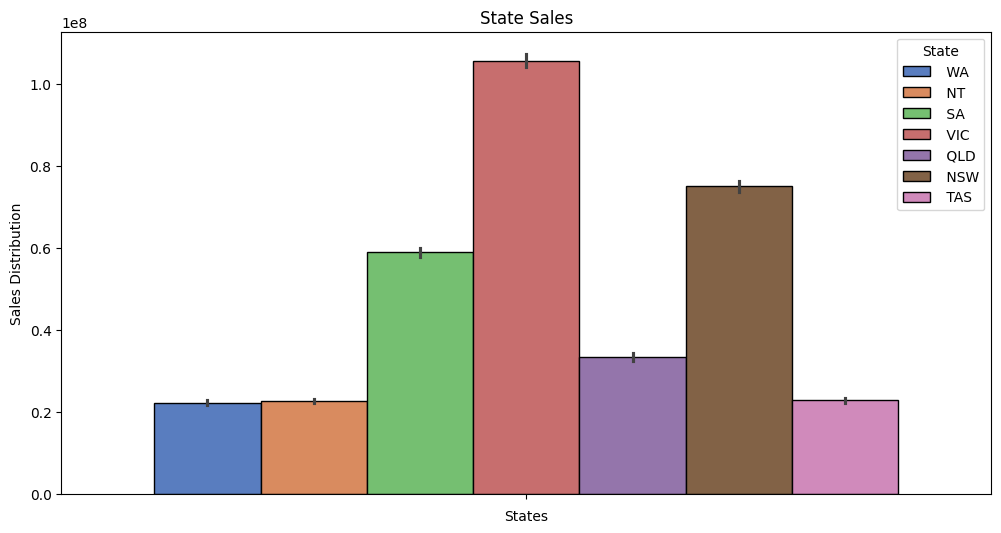

In [33]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, hue='State', y='Sales',estimator=sum, palette='muted', edgecolor='black')
plt.title("State Sales")
plt.xlabel("States")
plt.ylabel("Sales Distribution")
plt.show()

#### Pie Chart of States

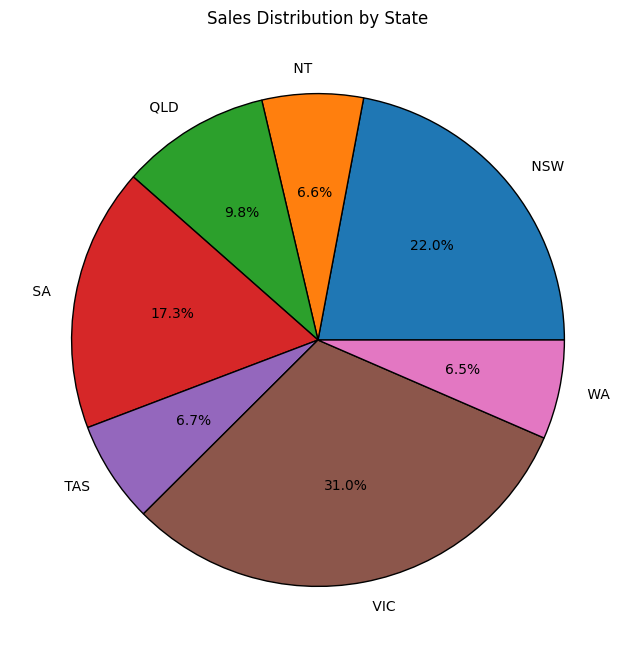

In [34]:
state_sales = df.groupby("State")["Sales"].sum()
plt.figure(figsize=(8, 8))
plt.pie(state_sales, labels=state_sales.index, autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'})
plt.title("Sales Distribution by State")
plt.show()

### Total Sales per Group

#### Barplot of Groups

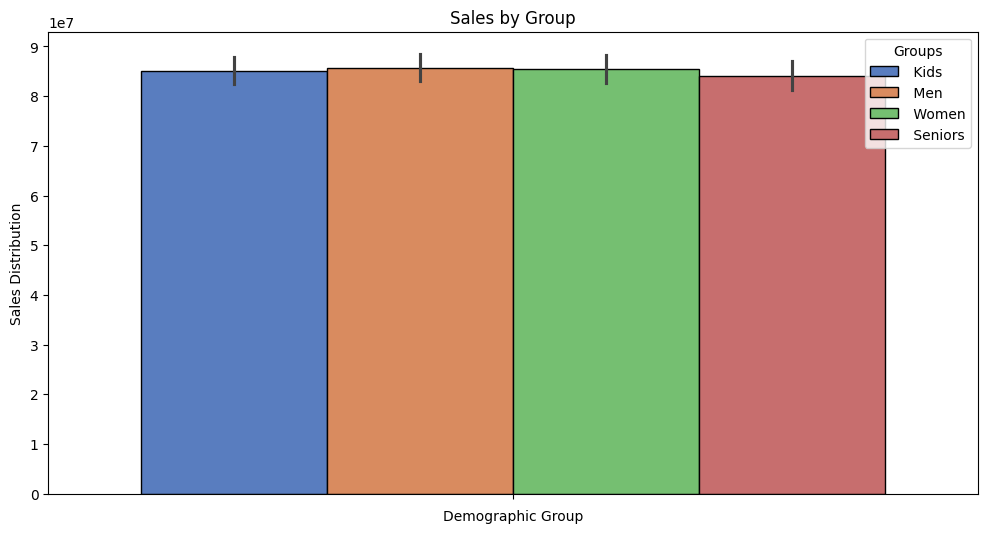

In [35]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, hue='Group', y='Sales',estimator=sum, palette='muted', edgecolor='black')
plt.title("Sales by Group")
plt.xlabel("Demographic Group")
plt.ylabel("Sales Distribution")
plt.yticks(np.arange(0, 100000000, 10000000))
plt.legend(title="Groups")
plt.show()

#### Pie Chart of Groups

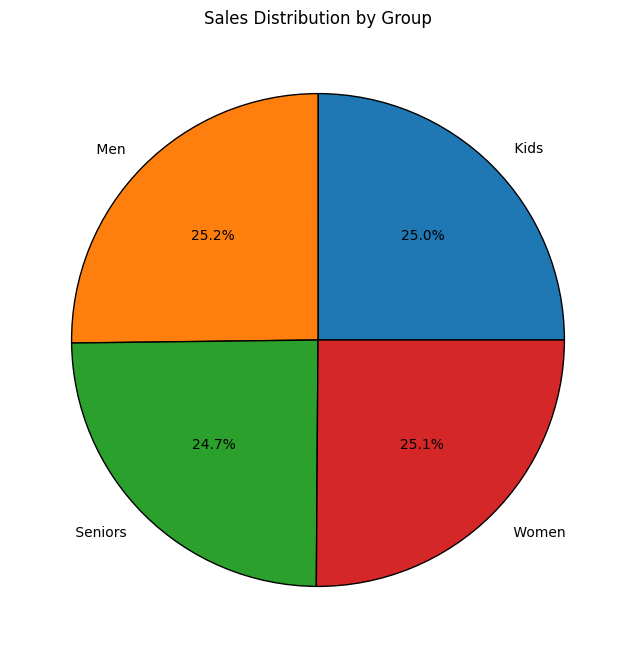

In [36]:
group_sales = df.groupby("Group")["Sales"].sum()
plt.figure(figsize=(8, 8))
plt.pie(group_sales, labels=group_sales.index, autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'})
plt.title("Sales Distribution by Group")
plt.show()

### Total Sales per Time of Day

#### Barplot of Sales through Time of Day

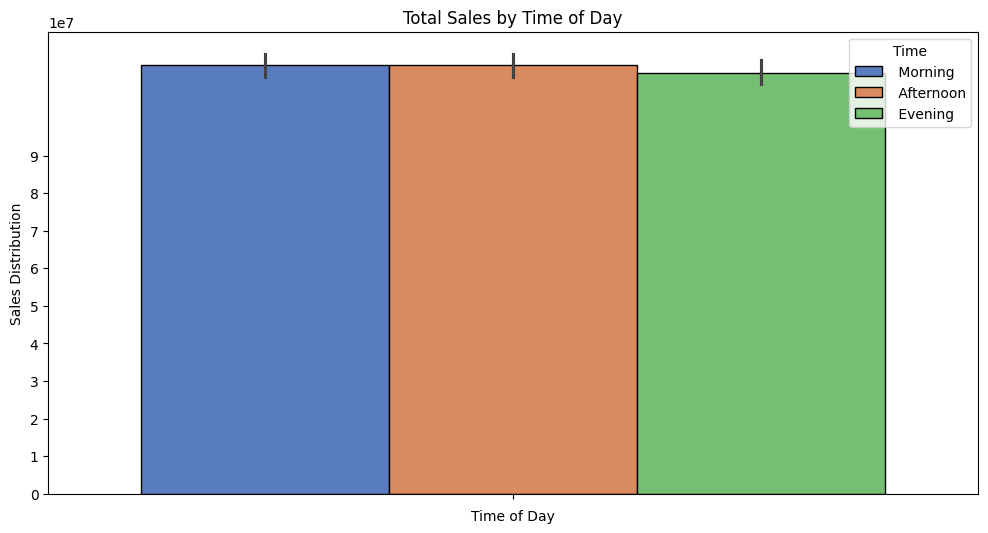

In [37]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, hue='Time', y='Sales',estimator=sum, palette='muted', edgecolor='black')
plt.title("Total Sales by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Sales Distribution")
plt.yticks(np.arange(0, 100000000, 10000000))
plt.legend(title="Time")
plt.show()

#### Pie Chart of Sales through Time of Day

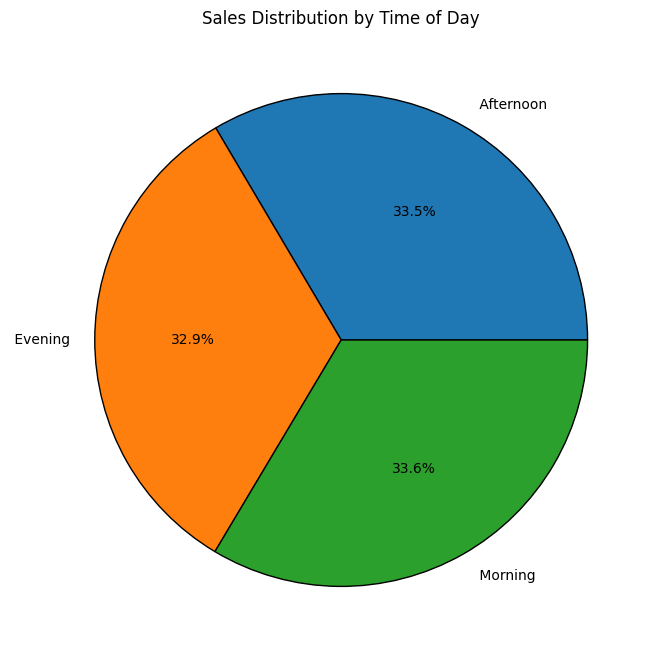

In [38]:
time_sales = df.groupby("Time")["Sales"].sum()
plt.figure(figsize=(8, 8))
plt.pie(time_sales, labels=time_sales.index, autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'})
plt.title("Sales Distribution by Time of Day")
plt.show()

## Aggregated Data Visualized

### State-wise sales analysis for different demographic groups (kids, women, men, and seniors).


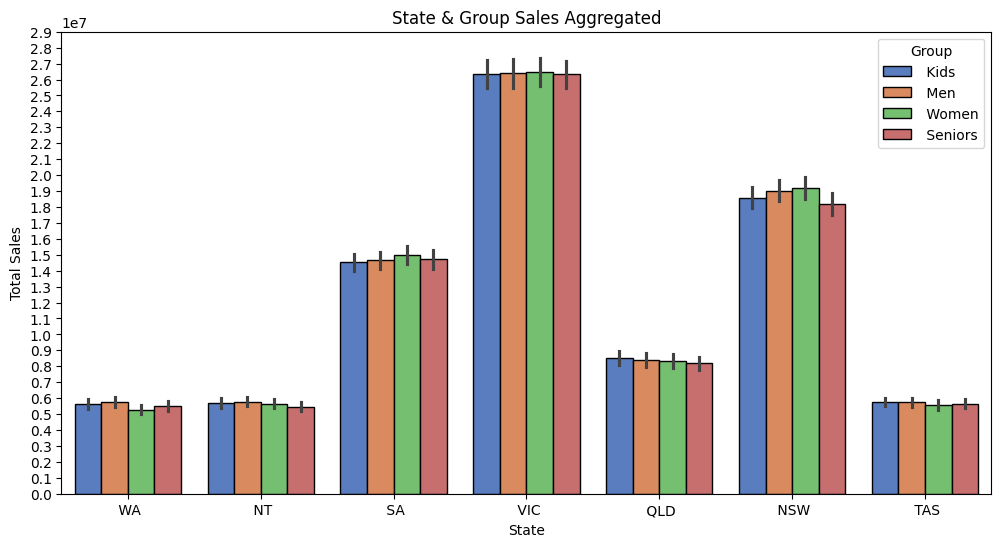

In [39]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='State', y='Sales', hue='Group', estimator=sum, palette='muted', edgecolor='black')
plt.title("State & Group Sales Aggregated")
plt.xlabel("State")
plt.ylabel("Total Sales")
plt.yticks(np.arange(0, 30000000, 1000000))
plt.legend(title="Group")
plt.show()


### Group-wise sales analysis (Kids, Women, Men, and Seniors) across various states.

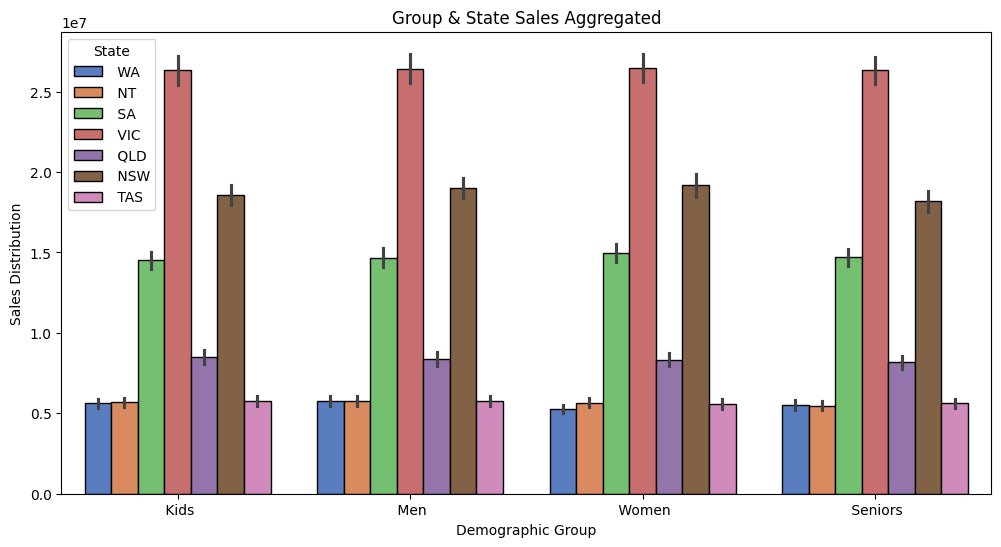

In [40]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Group', y='Sales', hue='State',estimator=sum, palette='muted', edgecolor='black')
plt.title("Group & State Sales Aggregated")
plt.xlabel("Demographic Group")
plt.ylabel("Sales Distribution")
plt.legend(title="State")
plt.show()

### Time-of-the-day analysis: Identify peak and off-peak sales periods to facilitate strategic planning for S&M teams.

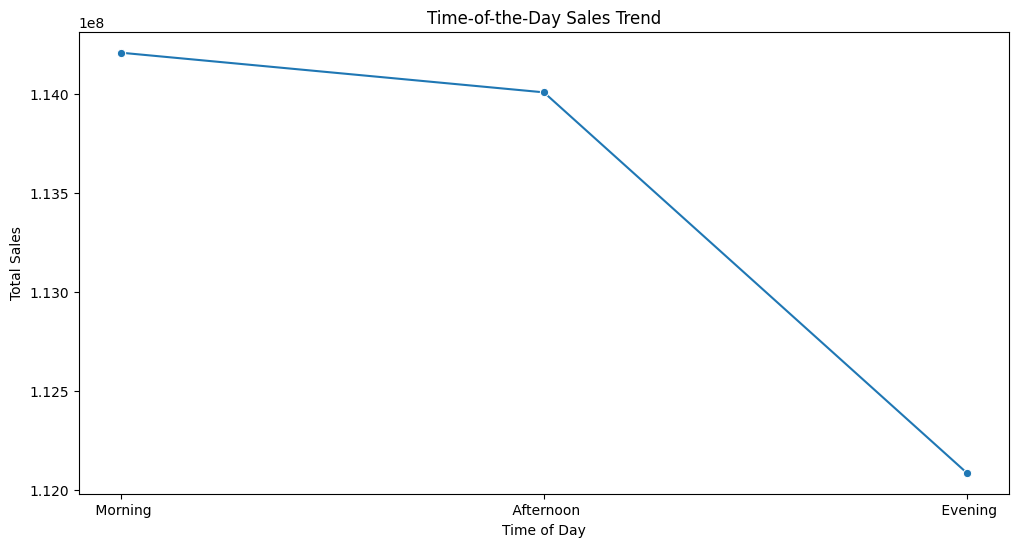

In [41]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=time_agg_sum.reset_index(), x='Time', y='Sales', estimator= sum, marker='o')
plt.title("Time-of-the-Day Sales Trend")
plt.xlabel("Time of Day")
plt.ylabel("Total Sales")
plt.show()

## Temporal Sales Reports

### Barplot of Daily Sales

/var/folders/q9/tcnkwbxn3pv75_gj_6zrz_c80000gn/T/ipykernel_6087/556979438.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=daily_agg, x='Date', y='Sales', palette="muted", edgecolor = 'black')


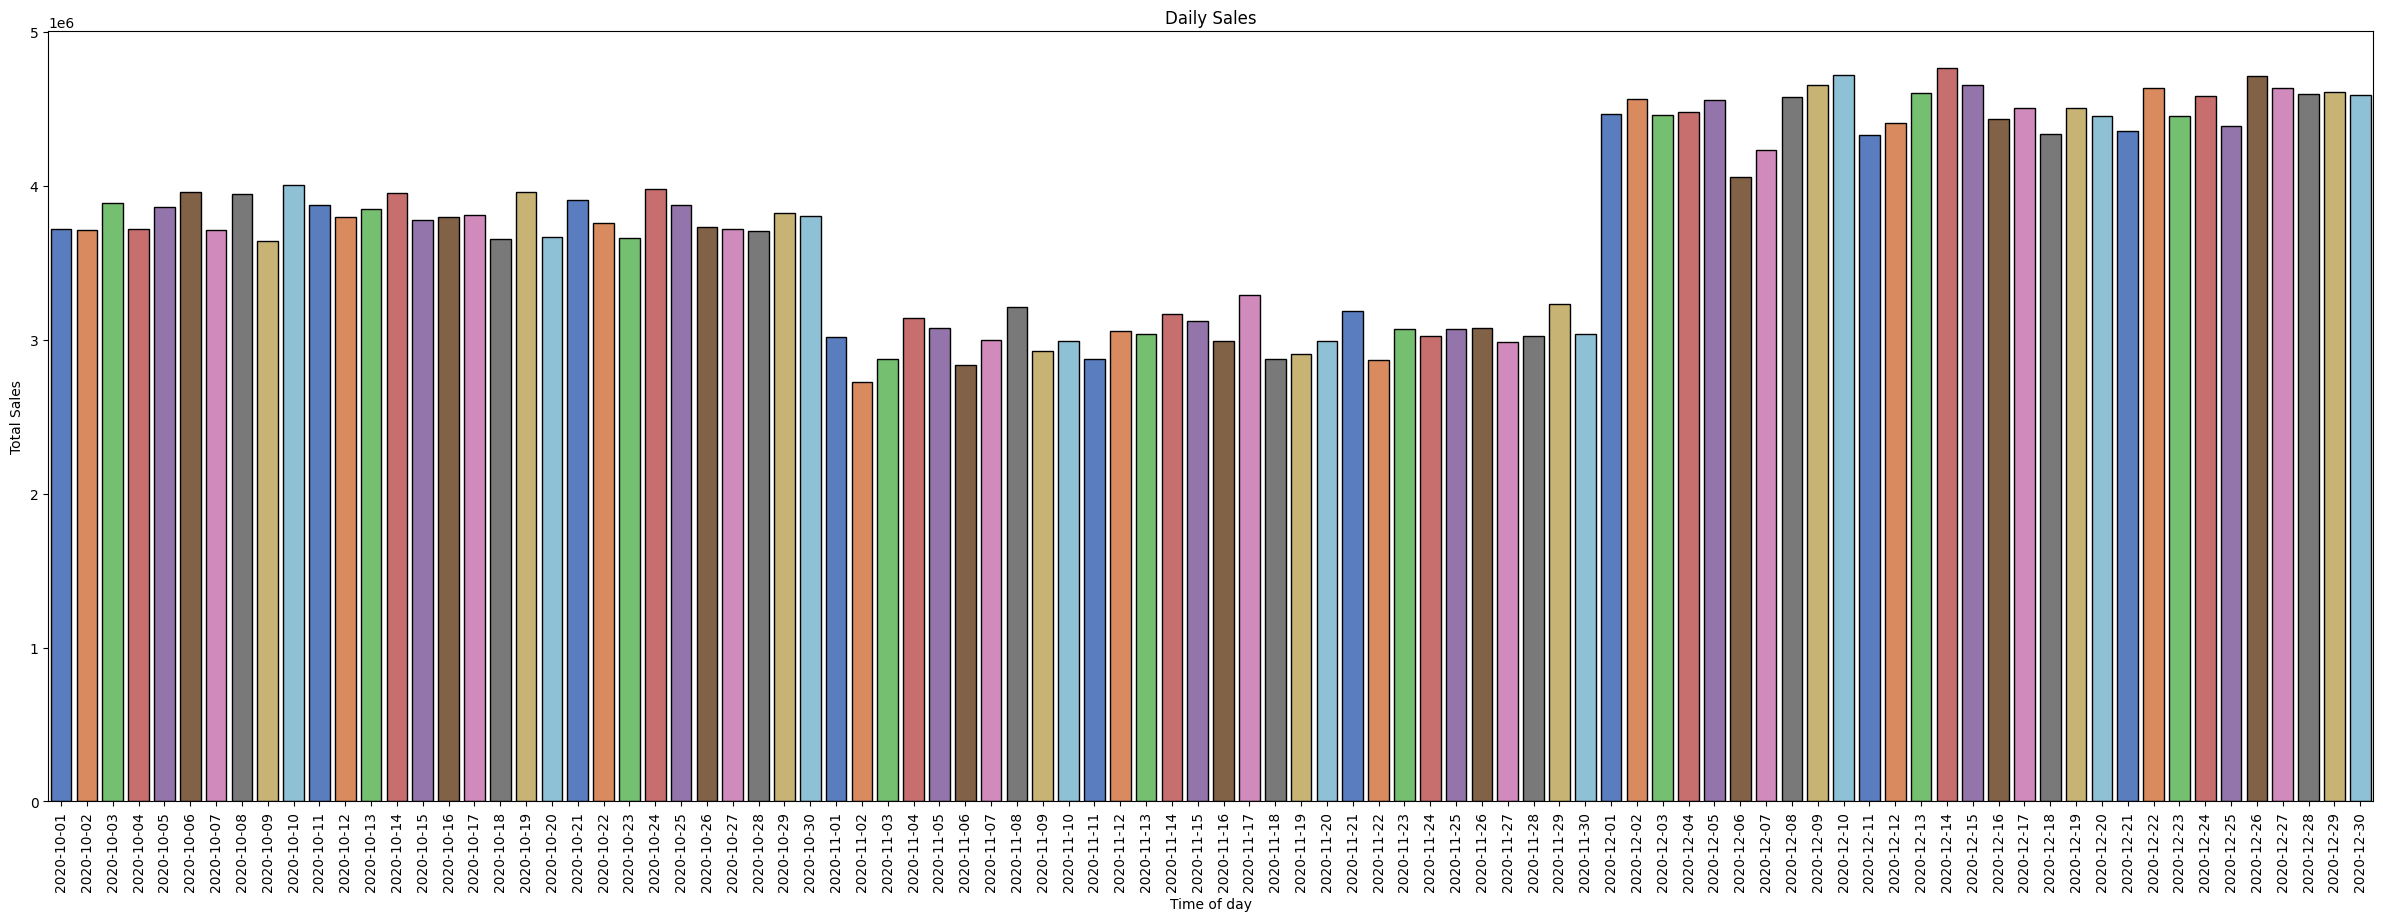

In [42]:
daily_agg = df.groupby(['Date'])['Sales'].sum().reset_index()

plt.figure(figsize=(30, 10))
sns.barplot(data=daily_agg, x='Date', y='Sales', palette="muted", edgecolor = 'black')
plt.xticks(rotation=90)
plt.title("Daily Sales")
plt.xlabel("Time of day")
plt.ylabel("Total Sales")
plt.show()

### Lineplot of Daily Sales

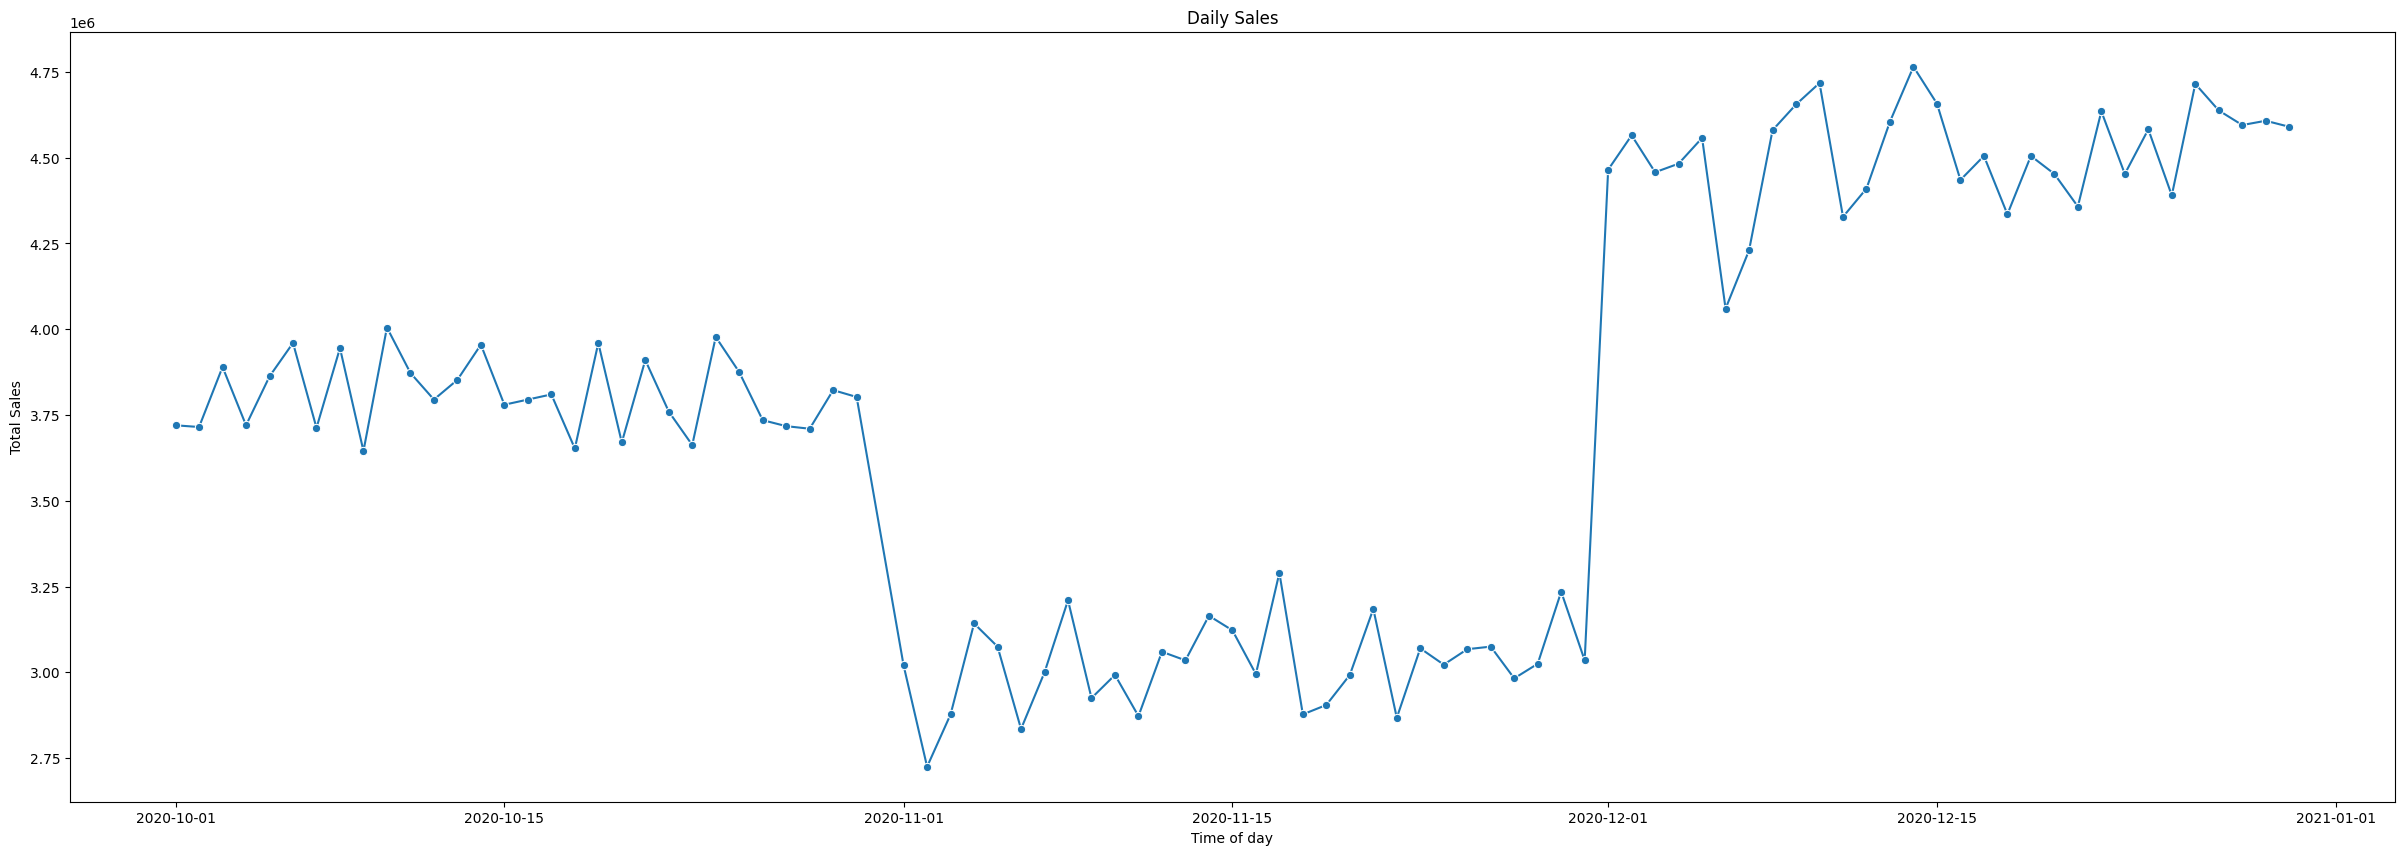

In [43]:
plt.figure(figsize=(30, 10))
sns.lineplot(data=daily_agg, x='Date', y='Sales', estimator=sum, marker='o')
plt.title("Daily Sales")
plt.xlabel("Time of day")
plt.ylabel("Total Sales")
plt.show()

### Barplot of Weekly Sales

/var/folders/q9/tcnkwbxn3pv75_gj_6zrz_c80000gn/T/ipykernel_6087/4204383652.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=weekly_sales, x='Week', y='Sales',palette="muted", edgecolor = 'black')


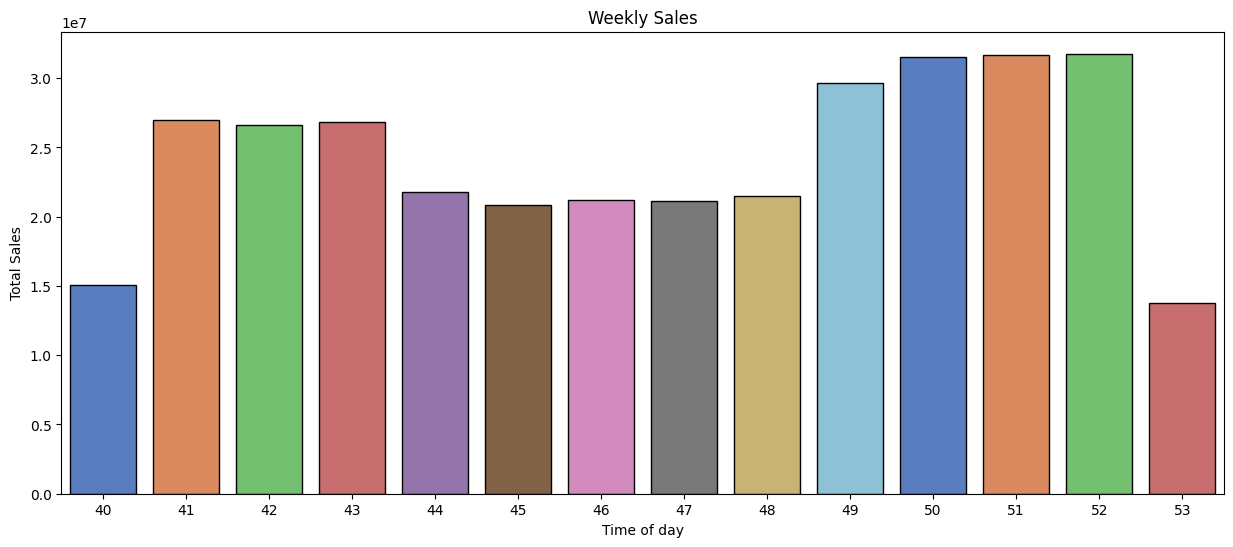

In [44]:
plt.figure(figsize=(15, 6))
sns.barplot(data=weekly_sales, x='Week', y='Sales',palette="muted", edgecolor = 'black')
plt.title("Weekly Sales")
plt.xlabel("Time of day")
plt.ylabel("Total Sales")
plt.show()

Weeks 40 and 53 are visible outliers

### Barplot Weekly Sales (excluding outliers)

/var/folders/q9/tcnkwbxn3pv75_gj_6zrz_c80000gn/T/ipykernel_6087/3096599354.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_sales, x='Week', y='Sales',palette="muted", edgecolor = 'black')


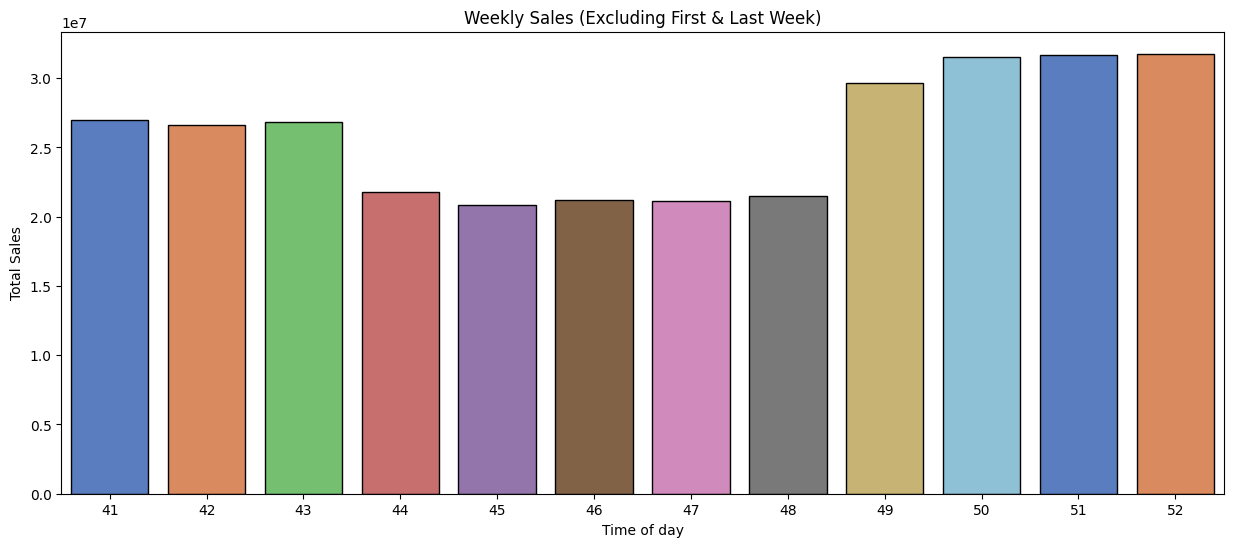

In [45]:
plt.figure(figsize=(15, 6))
sns.barplot(data=filtered_sales, x='Week', y='Sales',palette="muted", edgecolor = 'black')
plt.title("Weekly Sales (Excluding First & Last Week)")
plt.xlabel("Time of day")
plt.ylabel("Total Sales")
plt.show()

### Line Plot of Weekly Sales

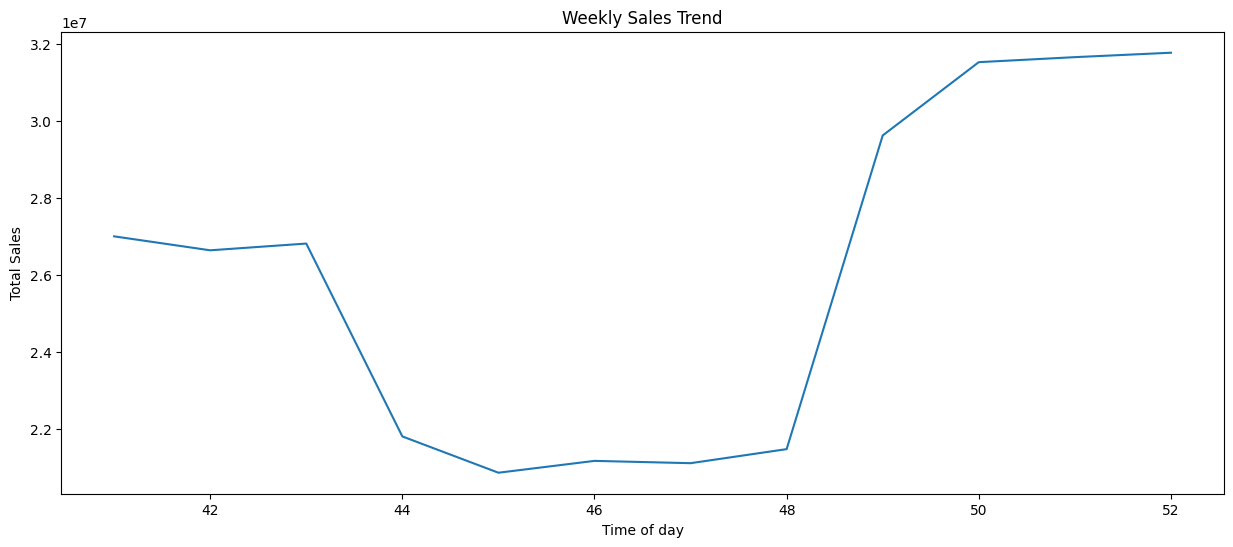

In [46]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=filtered_sales, x='Week', y='Sales')
plt.title("Weekly Sales Trend")
plt.xlabel("Time of day")
plt.ylabel("Total Sales")
plt.show()

### Barplot of Monthly Sales

/var/folders/q9/tcnkwbxn3pv75_gj_6zrz_c80000gn/T/ipykernel_6087/3426324369.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_sales, x='Month', y='Sales',palette="muted", edgecolor = 'black')


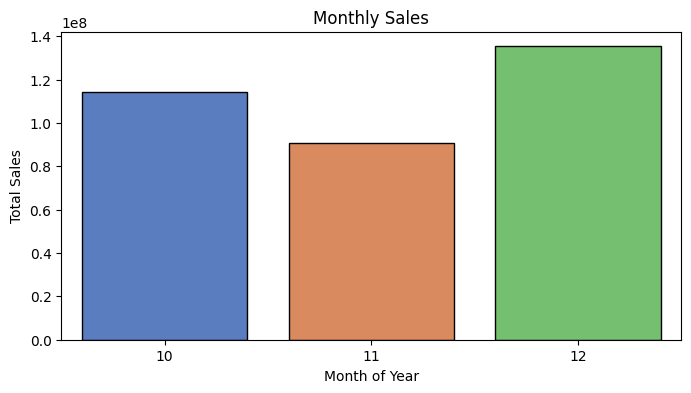

In [47]:
plt.figure(figsize=(8, 4))
sns.barplot(data=monthly_sales, x='Month', y='Sales',palette="muted", edgecolor = 'black')
plt.title("Monthly Sales")
plt.xlabel("Month of Year")
plt.ylabel("Total Sales")
plt.show()

### Lineplot of Monthly Sales

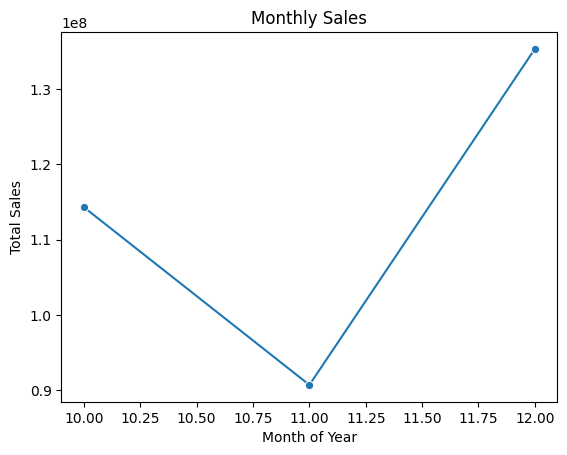

In [48]:
# plt.figure(figsize=(30, 10))
sns.lineplot(data=monthly_sales, x='Month', y='Sales', estimator=sum, marker='o')
plt.title("Monthly Sales")
plt.xlabel("Month of Year")
plt.ylabel("Total Sales")
plt.show()

# Report generation


### Regional Sales Analysis Report
As seen visually on the Total Sales by State barplot and pie chart, the State of Victoria generated the most revenue of $105,565,000. The State-Group aggregated data, illustrated via barplot, also visually shows Victoria was the most lucrative in all demographic groups as well. The lowest sales regionally was Western Australia, yielding $22,152,500, suggesting further investigation may be needed in this area for possible market campaigning to boost sales or reallocation of staff and resources toward the more lucrative states to further capitalize on the interest in the products. ANOVA testing among states demonstrate there is statistical difference between sales among the states.

### Demographic Group Sales Analysis Report

The highest revenue-generating group was technically Men's clothing, yielding $85,750,000, and the lowest revenue-generating group was Seniors' clothing, yielding $84,037,500. However, ANOVA testing shows that there is no statistical difference among group sales. The pie chart illustrates this more clearly, emphasizing how closely balanced these sales groups are relative to each other. Visualization of the barplot group data aggragated with regional data shows similar shapes between states as well. A larger sample size may be needed to suggest statistical difference between group sales. 

### Temporal Sales Analysis Report
Within the three-month data set, December was the most lucrative month, grossing $135,330,000. November yielded the least sales cumulatively, $90,682,500. This trend can be more easily seen via the line plot of daily, weekly, and monthly sales. Deeper examination through weekly reports and viewing the weekly barplot, show that the week of 12/21-12/27, was the high week for sales. This date range may suggest trends related to the Christmas holiday pre- and post- shopping surges. However, the lowest week of sales was the first and last weeks of the data set, containing incomplete week days at cut offs, resulting in shorter week of the year and a lower sale yield cumulatively. After eliminating the first and last week from the data set, the week of 11-02 to 11-08 as found to have the lowest sales. 

Other interesting points of the temporal data were that sales were generally highest during the morning, followed by the afternoon, and finally the evening as seen via the line plot of sales throughout the day. The Barplot and pie chart of total sales at different times of the day, shows greatest decline in sales during the evening. ANOVA testing suggests difference among time of day sales are statistically significant. Additionally, dates with the lowest sales ($5000 or 2 units) and highest sales ($162,500 or 65 units) were calculated for further examination if desired.